### **Libraries:**

In [ ]:
!pip install plot-metric
!pip install xgboost
!pip install TurkishStemmer
!pip install nltk
!pip install xlwt
!pip install sklearn-genetic-opt
!pip install sklearn-genetic-opt[all]

import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics, tree, svm, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer
from IPython.display import display, HTML
from sklearn_genetic import GASearchCV, ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
import pandas as pd
import numpy as np
import os
import re
import nltk
import pickle
import openpyxl
import statistics
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from datetime import datetime
from pytz import timezone
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import seaborn as sns

nltk.download('stopwords')
stemmer = TurkishStemmer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Functions:**

In [ ]:
dataset="news"

#Shows which words most often decide on the relevant category
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)

#Data preparation phase (removing unnecessary characters, words etc.), returns the corpus
def prepare_data(data,text_column=0, add_two_grams=False):
    corpus = []
    i = 0
    for i in range(0, len(data)):
        try:
            x = data.iloc[i][text_column]
            sentence = re.sub("\W+", " ", x)
            sentence = sentence.replace("İ","i")
            sentence = sentence.replace("I","ı")
            sentence = sentence.lower()
            word_list = sentence.split()
            stemmed_word_list = []

            prevWord = "" #two_grams için

            for word in word_list:
                if not word in stopwords.words('turkish'):
                    if word.isalpha():
                        try:
                          stemmed_word_list.append(stemmer.stem(word))

                          if add_two_grams:
                            phrase = prevWord + word
                            stemmed_word_list.append(stemmer.stem(phrase))
                            prevWord = word

                        except Exception as ex2:
                          pass

            new_sentence = re.sub("\W+"," ",re.sub(r'\b[a-zA-Z]{1}\b', " ", re.sub("\d", "", " ".join(stemmed_word_list))))
            corpus.append(new_sentence)
        except Exception  as ex:
            x = data.iloc[i][text_column]
            corpus.append(" ")
            print("err docid:"+str(i)+":"+str(x)+"---")
            print(ex)
    return(corpus)

#Generates a result report with the given dataset and input file, either by calling the file from model_name or by using the model and the CountVectorizer itself
def prepare_output(dataset, test_filename, model_name="", model=None):
  input_data = pd.read_excel(test_filename)
  cv = pickle.load(open("ai_vectorizer_" + dataset + ".pkl", 'rb'))

  if model is None:
    model = pickle.load(open("ai_model_" + dataset + "_" + model_name + ".pkl", 'rb'))

  input_data_corpus = prepare_data(input_data, add_two_grams=False)
  cv_test = CountVectorizer(max_features=10000,vocabulary=cv.get_feature_names_out())
  X_test_real = cv_test.fit_transform(input_data_corpus)

  if model_name == "XGBClassifier":
    label_encoder = pickle.load(open("ai_labelencoder_" + dataset + "_XGBClassifier.pkl", 'rb'))
    predictions = model.predict(X_test_real)
    predictions_decoded = label_encoder.inverse_transform(predictions)
    predictions_df = pd.DataFrame(predictions_decoded, columns=['Predictions'])
  else:
    predictions = model.predict(X_test_real)
    predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

  rapor = pd.concat([input_data, predictions_df], axis=1)

  return(rapor)

#Builds corpus, runs model, cross validation, hyperparameter search
def model_build(dataset, model, subset='data', prepare_corpus=False, add_two_grams=False, build_model=True, make_crossval=False, folds_for_cv=5, make_genetic_opt=False, make_gridsearch_opt=False, make_randomized_opt=False, param_grid=None):
  model_name = model.__class__.__name__
  training_data = pd.read_excel("training_data_" + dataset + ".xlsx", sheet_name=subset)
  training_data.columns = ['text', 'label']
  class_count = training_data.label.unique().size #Binary mi multi-class mı?
  row_count = training_data.text.size

  print("---------------- " + dataset + " - " + subset + " - " + model_name + " - row count:" + str(row_count) + " ----------------")
  start_time = datetime.now(timezone('Europe/Istanbul'))
  print("Start Time = " + start_time.strftime("%H:%M:%S"))

  data_corpus = None

  if prepare_corpus: #Is it requested to prepare data_corpus?
    data_corpus = prepare_data(training_data, add_two_grams=add_two_grams) #prepare data_corpus
    pickle.dump(data_corpus, open("data_corpus_" + dataset + ".pkl","wb")) #save data_corpusu
  else:
    data_corpus = pickle.load(open("data_corpus_" + dataset + ".pkl", 'rb')) #get the data_corpus from file

  if build_model: #Is it requested to train the model?
    cv = CountVectorizer(max_features=10000)
    X = cv.fit_transform(data_corpus).toarray()
    pickle.dump(cv, open("ai_vectorizer_" + dataset + ".pkl","wb")) #Save the CountVectorizer

    y = training_data.label

    if model_name == "XGBClassifier":
      #In XGBClassifier, the y column is considered as a numeric value, so it is necessary to encode it.
      label_encoder = preprocessing.LabelEncoder().fit(y)
      pickle.dump(label_encoder, open("ai_labelencoder_" + dataset + "_" + model_name + ".pkl","wb")) #Save the LabelEncoder
      y = label_encoder.transform(y)

    if make_genetic_opt: #Find optimal parameters using genetic algorithm
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)
      skf = StratifiedKFold(n_splits=folds_for_cv, shuffle=True)
      #evolved_estimator = GASearchCV(estimator=model, cv=skf, scoring='accuracy', population_size=6, generations=8, param_grid=param_grid, n_jobs=-1, verbose=True)
      evolved_estimator = GASearchCV(estimator=model, cv=skf, scoring='accuracy', population_size=10, generations=10, param_grid=param_grid, n_jobs=-1, verbose=True)
      evolved_estimator.fit(X_train, y_train)
      y_predict = evolved_estimator.predict(X_test)
      acc = accuracy_score(y_test, y_predict)

      print("Best accuracy through Genetic Opt: ", acc)
      print("Best parameters: ", evolved_estimator.best_params_)

      pickle.dump(evolved_estimator.estimator, open("ai_model_" + dataset + "_" + model_name + "_geneticOpt.pkl", "wb")) #save the optimized model

      model = evolved_estimator
    elif make_gridsearch_opt: #Find optimal parameters using GridSearchCV
      skf = StratifiedKFold(n_splits=folds_for_cv)
      gridsearched_estimator = GridSearchCV(model, param_grid, n_jobs=-1, cv=skf, verbose=2).fit(X, y)

      print('Best accuracy through GridSearch : {:.3f}'.format(gridsearched_estimator.best_score_))
      print('Best parameters : {}\n'.format(gridsearched_estimator.best_params_))

      pickle.dump(gridsearched_estimator.estimator, open("ai_model_" + dataset + "_" + model_name + "_gridsearchOpt.pkl", "wb")) #save the optimized model

      model = gridsearched_estimator
    elif make_randomized_opt: #Find optimal parameters using RandomizedSearchCV
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)
      skf = StratifiedKFold(n_splits=folds_for_cv)
      randomized_estimator = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=skf, n_iter=10, n_jobs=-1, verbose=3)
      randomized_estimator.fit(X_train, y_train)
      y_predict = randomized_estimator.predict(X_test)
      accuracy = accuracy_score(y_test, y_predict)

      print("The best parameters are: ", randomized_estimator.best_params_)
      print("The best score: ", randomized_estimator.best_score_)
      print(f"The test accuracy using best parameters: {accuracy:.2f}")

      pickle.dump(randomized_estimator.estimator, open("ai_model_" + dataset + "_" + model_name + "_randomizedsearchOpt.pkl", "wb")) #save the optimized model
      model = randomized_estimator
    else: #Train a single model
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 20, stratify=y)
      model.fit(X_train, y_train)
      pickle.dump(model, open("ai_model_" + dataset + "_" + model_name + ".pkl", "wb")) #Save the model to a pickle file

      y_pred = model.predict(X_test)
      y_pred_train = model.predict(X_train)

      #train_accuracy = accuracy_score(y_train, y_pred_train)
      test_accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted')
      recall = recall_score(y_test, y_pred, average='weighted')
      f1score = f1_score(y_test, y_pred, average='weighted')

      probs = model.predict_proba(X_test)

      roc_auc = 0
      if class_count == 2:
        roc_auc = roc_auc_score(y_test, probs[:,1], average = 'weighted') #probs is 2-dimensional for binary classification
      else:
        roc_auc = roc_auc_score(y_test, probs, multi_class='ovo', average = 'weighted') #probs is 1-dimensional for multi-class

      #print(classification_report(y_test,y_pred)) #too many information
      print("Accuracy = %0.3f" % test_accuracy)
      print("Precision = %0.3f" % precision)
      print("Recall = %0.3f" % recall)
      print("F1 Score = %0.3f" % f1score)
      print("Roc_auc Score = %0.3f" % roc_auc)

      if make_crossval: #Do cross validation (folds_for_cv: Specifies how many pieces to split)
        skf = StratifiedKFold(n_splits=folds_for_cv)
        scores = cross_val_score(model, X, y, cv=skf)
        print(folds_for_cv, "-fold Stratified Cross Validation's Accuracy & St. Dev: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

      cf_matrix = confusion_matrix(y_test, y_pred)
      categories = training_data.label.unique()
      make_confusion_matrix(cf_matrix, model_name, dataset, categories=categories, accuracy = test_accuracy)

  end_time = datetime.now(timezone('Europe/Istanbul'))
  delta = end_time - start_time
  sec = delta.total_seconds()
  min = sec / 60

  print("End Time = " + end_time.strftime("%H:%M:%S"))
  print("Running Time in Minutes: {:.3f}".format(min))
  print("----------------------------------------------------------------")

  return model

#For details: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          model_name,
                          dataset,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          accuracy=-1):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        if accuracy == -1:
          accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Real Labels')
        plt.xlabel('Predicted Labels' + stats_text)
    else:
        plt.xlabel(stats_text)

    plt.title("".join([model_name, " - ", dataset]))

#Runs all classification algorithms for a specific dataset passed
def train_all_models(dataset, subset='data', prepare_corpus=False, make_crossval=False, folds_for_cv=5):
  classifier_collection = {}

  print("Active Dataset: " + dataset + "-" + subset)

  classifier_collection['MultinomialNB'] = model_build(dataset, MultinomialNB(), subset=subset, prepare_corpus=prepare_corpus, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['GaussianNB'] = model_build(dataset, GaussianNB(), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['BernoulliNB'] = model_build(dataset, BernoulliNB(), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['KNeighborsClassifier'] = model_build(dataset, KNeighborsClassifier(), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['LogisticRegression'] = model_build(dataset, LogisticRegression(random_state=0, class_weight='balanced'), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['DecisionTreeClassifier'] = model_build(dataset, tree.DecisionTreeClassifier(), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  classifier_collection['RandomForestClassifier'] = model_build(dataset, RandomForestClassifier(), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)
  #classifier_collection['SVC'] = model_build(dataset, svm.SVC(kernel='sigmoid', decision_function_shape = 'ovo', probability=True), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)   #SVC hem gereksiz uzun sürüyor hem de genellikle accuracy score'u kötü
  classifier_collection['XGBClassifier'] = model_build(dataset, XGBClassifier(tree_method='gpu_hist', device='cuda'), subset=subset, make_crossval=make_crossval, folds_for_cv=folds_for_cv)

  return classifier_collection

### **Model Training:**

Active Dataset: news-data
---------------- news - data - MultinomialNB - row count:9792 ----------------
Start Time = 10:14:20
Accuracy = 0.875
Precision = 0.884
Recall = 0.875
F1 Score = 0.872
Roc_auc Score = 0.982
End Time = 10:17:00
Running Time in Minutes: 2.668
----------------------------------------------------------------
---------------- news - data - GaussianNB - row count:9792 ----------------
Start Time = 10:17:01
Accuracy = 0.756
Precision = 0.774
Recall = 0.756
F1 Score = 0.738
Roc_auc Score = 0.783
End Time = 10:17:08
Running Time in Minutes: 0.122
----------------------------------------------------------------
---------------- news - data - BernoulliNB - row count:9792 ----------------
Start Time = 10:17:09
Accuracy = 0.666
Precision = 0.692
Recall = 0.666
F1 Score = 0.659
Roc_auc Score = 0.948
End Time = 10:17:14
Running Time in Minutes: 0.088
----------------------------------------------------------------
---------------- news - data - KNeighborsClassifier - row cou

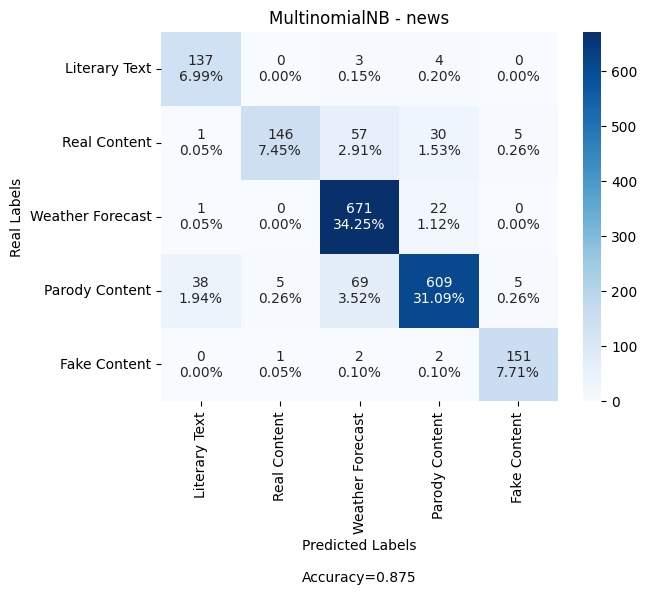

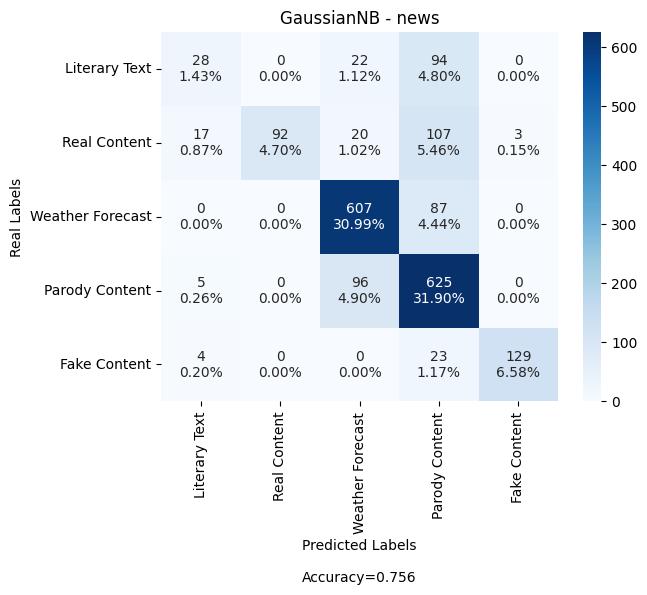

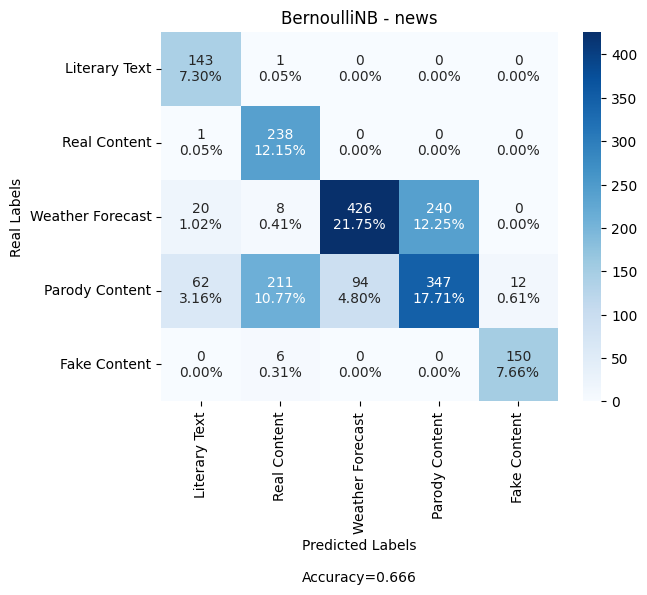

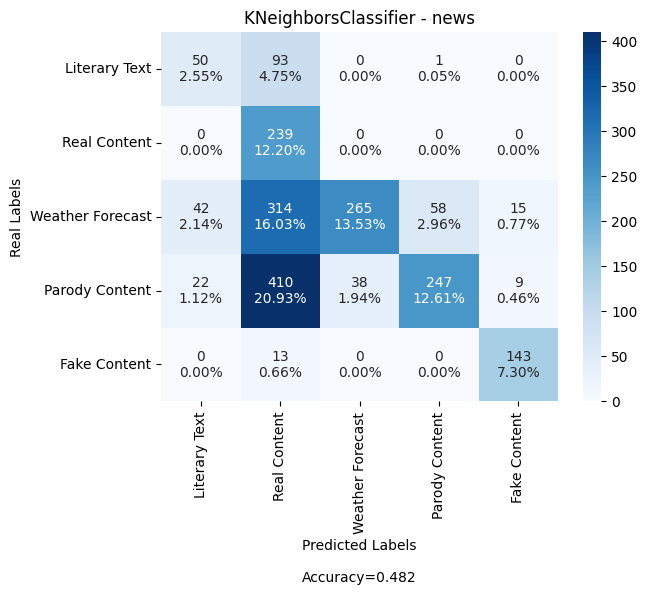

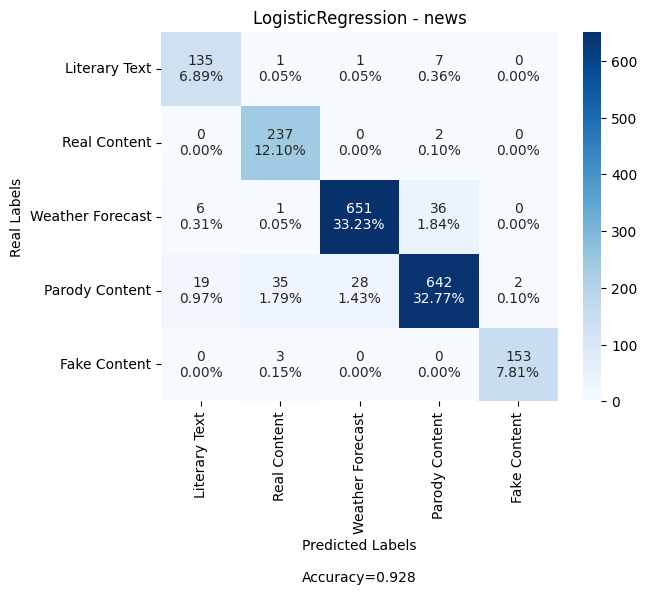

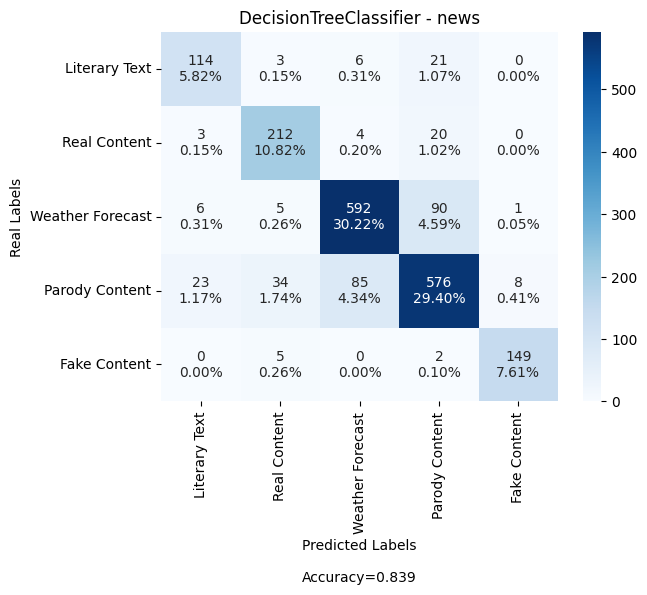

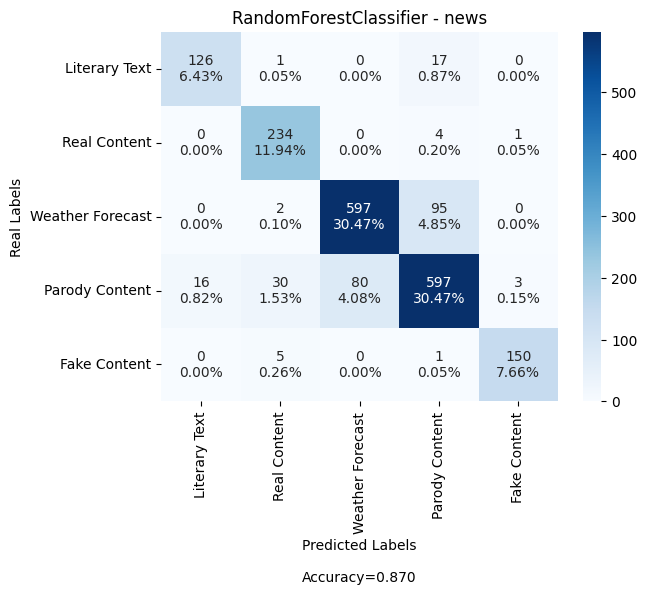

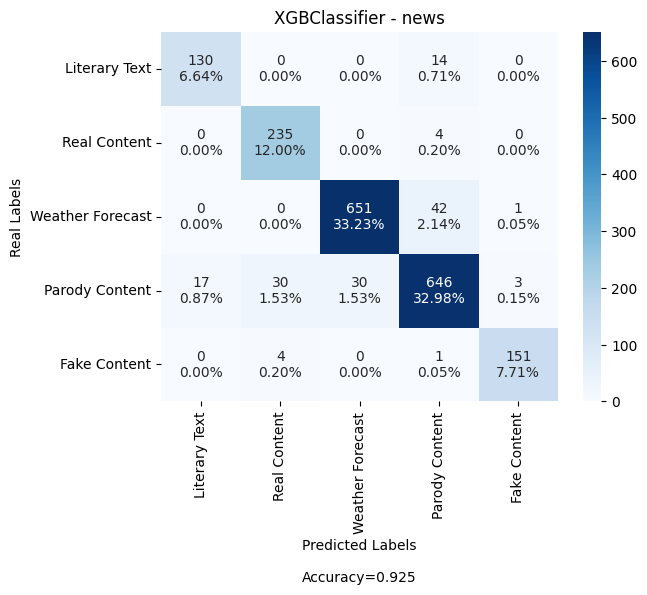

In [ ]:
#Train all the models
train_all_models(dataset, subset='data', prepare_corpus=True) #prepare_corpus=False
print("----")

### **Hyperparemeter Tuning:**

In [ ]:
#Hyperparameter Tuning for XGBClassifier

#RandomizedSearch Opt.
params_for_random = {'tree_method' :['hist'], 'device' :['cuda'], 'min_child_weight': sp_randInt(1, 40), 'gamma': sp_randFloat(0.1, 10), 'subsample': sp_randFloat(0.1, 1), 'colsample_bytree': sp_randFloat(0.1, 1), 'max_depth': sp_randInt(2, 20)}
random_model = model_build(dataset, XGBClassifier(tree_method='gpu_hist'), subset='data', make_randomized_opt=True, folds_for_cv=10, param_grid=params_for_random)
print("RandomizedSearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, XGBClassifier(**random_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

#Genetic Opt.
params_for_genetic = {'tree_method': Categorical(['hist']), 'device': Categorical(['cuda']), 'min_child_weight': Integer(1, 40), 'gamma': Continuous(0.1, 10, distribution='log-uniform'), 'subsample': Continuous(0.1, 1, distribution='log-uniform'), 'colsample_bytree': Continuous(0.1, 1, distribution='log-uniform'), 'max_depth': Integer(2, 20)}
genetic_model = model_build(dataset, XGBClassifier(tree_method='gpu_hist'), subset='data', make_genetic_opt=True, folds_for_cv=10, param_grid=params_for_genetic)
print("GASearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, XGBClassifier(**genetic_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

#GridSearch Opt.
params_for_grid = {'tree_method' :['hist'], 'device' :['cuda'], 'min_child_weight': [1, 5, 10, 40], 'gamma': [0.5, 1, 1.5, 2, 5, 10], 'subsample': [0.1, 0.5, 1.0], 'colsample_bytree': [0.1, 0.5, 1.0], 'max_depth': [2, 5, 10, 20]}
grid_model = model_build(dataset, XGBClassifier(), subset='data', make_gridsearch_opt=True, folds_for_cv=5, param_grid=params_for_grid)
print("GridSearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, XGBClassifier(**grid_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

---------------- news - data - XGBClassifier - row count:9792 ----------------
Start Time = 10:18:24
Fitting 10 folds for each of 10 candidates, totalling 100 fits
The best parameters are:  {'colsample_bytree': 0.3562498140396245, 'device': 'cuda', 'gamma': 1.9439772159314994, 'max_depth': 17, 'min_child_weight': 7, 'subsample': 0.5161100355397717, 'tree_method': 'hist'}
The best score:  0.9154841725962417
The test accuracy using best parameters: 0.91
End Time = 10:22:19
Running Time in Minutes: 3.928
----------------------------------------------------------------
RandomizedSearchCV ile bulunan optimum hiperparametrelerle cross validation: 
---------------- news - data - XGBClassifier - row count:9792 ----------------
Start Time = 10:22:20
Accuracy = 0.910
Precision = 0.912
Recall = 0.910
F1 Score = 0.910
Roc_auc Score = 0.989
10 -fold Stratified Cross Validation's Accuracy & St. Dev: 0.91 (+/- 0.03)
End Time = 10:22:55
Running Time in Minutes: 0.585
----------------------------------

In [ ]:
#Hyperparameter Tuning for RandomForestClassifier

#RandomizedSearch Opt.
params_for_random = {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200]}
random_model = model_build(dataset, RandomForestClassifier(), subset='data', make_randomized_opt=True, folds_for_cv=10, param_grid=params_for_random)
print("RandomizedSearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, RandomForestClassifier(**random_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

#Genetic Opt.
params_for_genetic = {'n_estimators': Integer(200, 500), 'max_features': Categorical(['auto', 'sqrt', 'log2']), 'max_depth' : Integer(4, 8), 'criterion' :Categorical(['gini', 'entropy'])}
genetic_model = model_build(dataset, RandomForestClassifier(), subset='data', make_genetic_opt=True, folds_for_cv=10, param_grid=params_for_genetic)
print("GASearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, RandomForestClassifier(**genetic_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

#GridSearch Opt.
params_for_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}
grid_model = model_build(dataset, RandomForestClassifier(), subset='data', make_gridsearch_opt=True, folds_for_cv=10, param_grid=params_for_grid)
print("GridSearchCV ile bulunan optimum hiperparametrelerle cross validation: ")
the_model=model_build(dataset, RandomForestClassifier(**grid_model.best_params_), subset='data', make_crossval=True, folds_for_cv=10)

### **Prediction:**

In [ ]:
#Prepare the output file using the given input file, the dataset and the model
input_dosyasi_adi = "test_data_" + dataset + ".xlsx"
model_name = "XGBClassifier"
rapor = prepare_output(dataset, input_dosyasi_adi, model_name) #This function accepts the trained model itself as a parameter instead of model_name (Example: model=model_collection['MultinomialNB']))
rapor.to_excel("output_" + dataset + ".xlsx")